<a href="https://colab.research.google.com/github/Keenandrea/Regression/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle House Prices: or, My Exploration Into Advanced Regression Techniques

---

## imports and other fundamental tiddlywinks 

---

Basically, I'm leveraging *pandas* as my data analysis toolkit, and *numpy* for multi-dimensional arrays and matrices support along with magniloquent mathematical functions to operate on these arrays and other similarly magniloquent functions to model my architecture.

In [0]:
#pandas for my data
import pandas as pd
#numpy for my digits
import numpy as np
#seaborn for my plots
import seaborn as sns
#matplotlib, also for my plots
import matplotlib.pyplot as plt
#magic stores plots
%matplotlib inline

#lastly but not leastly: sklearn and xgboost to model my architecture with
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer



---


## reading train and test data into *pandas* dataframes

---



In [0]:
#read given training datas into a dataframe
train_df = pd.read_csv('housing_train.csv', index_col='Id')
#read given testing datas into a dataframe
test_df = pd.read_csv('housing_test.csv', index_col='Id')

Once the dataframes have been made I'll combine them to form one single dataframe, which simplifies the application of data transformation by acting upon both sets as one.

In [0]:
#put these aside for later
train_id = train_df.index
#put these aside for later
test_id = test_df.index

#weld training and testing dataframes into one
df = pd.concat([train_df, test_df], sort=True)



---


#sleuthing those NaN datas like Nancy Drew

---
Thing is, the missing data is neither MCAR, MAR, or MNAR, by true definition. Rather, it is absent instead of missing. Like, the *Alley* field has NaN values because the house under consideration does not have an alley. Same for *Fence*, *MiscFeature*, and so on.

My gut tells me to remove those NaN fields whose missing data reaches over 80%. However, the rule of thumb is to save as much data as possible. So, instead of dropping these NaN values, I'll change them.


In [4]:
#run this cell to locate NaNs
nan_values = df.isnull().sum()
nan_values = nan_values[nan_values>0]
print(nan_values.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


In [0]:
#create array of columns where NaN values are present 
nan_columns = ['PoolQC','MiscFeature','Alley','Fence',
               'MasVnrType','FireplaceQu','GarageQual',
               'GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual',
               'BsmtFinType1','BsmtFinType2']

In [0]:
#replace NaN with None
for col in nan_columns:
    df[col].fillna('None',inplace=True)



---

Regarding GarageYrBlt: if I replace missing values with 0.0, I create outliers; if I impute missing values, the year the garage was built could be far from the year the house itself was built, which, more often than not, is implausable. So instead I'll fill in the missing years with the year the house was built.

In [0]:
#rebrand GarageYrBlt's NaN values with the corresponding YearBuilt's present values
df.loc[df.GarageYrBlt.isnull(),'GarageYrBlt'] = df.loc[df.GarageYrBlt.isnull(),'YearBuilt']


---

Regarding MasVnrArea, BsmtFullBath, and GarageArea, and so on: one of two ways to fill these quantitatives: 1) replace with 0, for None; 2) Impute strategy. Since there aren't many missing values in any of these columns, I'll set them to zero, so as not to impute and realize I've banjaxed dependant variable elsewhere.

In [0]:
#house has no masonry veneer, replace
df.MasVnrArea.fillna(0,inplace=True)

#house has no basement, replace with 0    
df.BsmtFullBath.fillna(0,inplace=True)
df.BsmtHalfBath.fillna(0,inplace=True)
df.BsmtFinSF1.fillna(0,inplace=True)
df.BsmtFinSF2.fillna(0,inplace=True)
df.BsmtUnfSF.fillna(0,inplace=True)
df.TotalBsmtSF.fillna(0,inplace=True)

#house has no garage, replace with 0
df.GarageArea.fillna(0,inplace=True)
df.GarageCars.fillna(0,inplace=True)



---


## leveraging *Ridge* to handle NaNs

---
LotFrontage is one of the float data-types in my dataframe. I can't enter 0.0. That's ridiculous. I can impute the missing data, as per usual but that limits the predictions to mean, median, and so on, values. So, instead I'll handle it via *Ridge* Regression. We wo't go into that here, if you're interested, digress [here](https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e).  


In [0]:
#function normaliz
#es indicator data
#frame column valu
#es between 0 & 1.
def normalize(col):
  return (col-col.min())/(col.max()-col.min())

In [10]:
from sklearn.linear_model import Ridge
#converting from catagorical into dummy (indicator)
#or catagorical into a series of binary indicator c
#olumns that can be more easily used as features an
#d at the same time exlude the SalePrice column.
lf_df = pd.get_dummies(df.drop('SalePrice',axis=1))

#loop to drop columns in LotFrontage and replace col
#umn names in dummy (indicator) dataframe. then norm
#alize those indicator columns between 1 and 0.
for col in lf_df.drop('LotFrontage',axis=1).columns:
  lf_df[col] = normalize(lf_df[col])

#drop the NaN values
train_lf = lf_df.dropna()
#target values are LotFrontage
train_lf_y = train_lf.LotFrontage
#training values are everything but LotFrontage
train_lf_X = train_lf.drop('LotFrontage',axis=1)
 

rr = Ridge()
#fit model by train and target
rr.fit(train_lf_X, train_lf_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
rr_coefs = pd.Series(rr.coef_,index=train_lf_X.columns)

In [12]:
print('----------------')
print('Intercept:',rr.intercept_)
print('----------------')
print(rr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(rr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',rr.score(train_lf_X,train_lf_y))
print('----------------')

----------------
Intercept: 93.20848325396253
----------------
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.6889229361774905
----------------




---

## compare imputed datas against original datas

---

Running the following cell shows hope. The giant cluster of dots, minus outliers, which I'll tend to soon enough displays the imputation has done relatively well in finding closely knit imputes.

Text(0.5, 1.0, 'residual versus original')

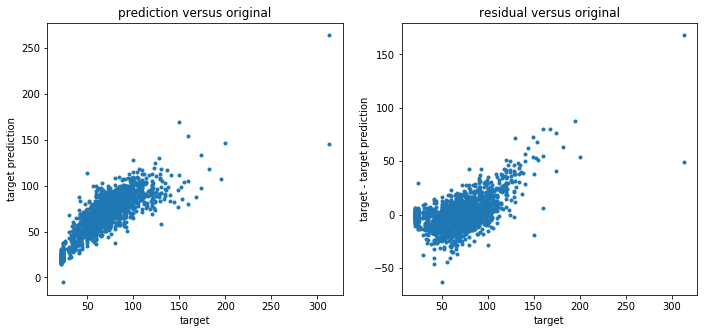

In [13]:
#instantiate predicted variables
pred_lf_y = rr.predict(train_lf_X)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(train_lf_y,pred_lf_y,'.')
plt.xlabel('target')
plt.ylabel('target prediction');
plt.title('prediction versus original')

plt.subplot(1,3,2)
plt.plot(train_lf_y, train_lf_y-pred_lf_y,'.')
plt.xlabel('target')
plt.ylabel('target - target prediction');
plt.title('residual versus original')



---

## filling NaNs using *Ridge* predictions

---



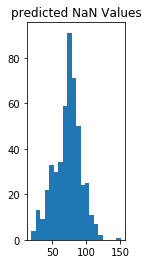

In [14]:
#fill NaN values using model predictions
nan_frontage = df.LotFrontage.isnull()
X = lf_df[nan_frontage].drop('LotFrontage',axis=1)
y = rr.predict(X)
#plot the predicts
plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('predicted NaN Values')
#finally, if satisfied, fill LotFrontage
df.loc[nan_frontage,'LotFrontage'] = y

A scatter of NaN values remain here and there, none of which reach numbers greater than 4 in any given column. Safe to say I can simply replace these missing NaNs with the mode per feature.

In [15]:
#working on remaining features containing NaN values
nan_cols = df.drop('SalePrice',axis=1).isnull().sum()
nan_cols = nan_cols[nan_cols>0]
#print the names of columns with NaNs still
print(nan_cols.sort_values(ascending=False))

#working on remaining row properties containing NaN values
nan_rows = df.drop('SalePrice',axis=1).isnull().sum(axis=1)
nan_rows = nan_rows[nan_rows>0]
#print the names of rows still having NaNs
print(nan_rows.sort_values(ascending=False))

#there really aren't substanti
#ally NaN-heavy anythings left
#so I'll fill remaining NaNs w
#ith the mode of each column.
for col in nan_cols.index:
    df[col].fillna(df[col].mode()[0], inplace=True)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64
Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29



---

## strongly NaNless in need of direction

---

Where do I go from here? NaNs are 86'd. Time to start sleuthing the datas, drawing connections, and breaking things. 

---

## feature engineering the basement datas

---
As good a place to start as ever. In short, I'll feature engineer these variables to represent the fraction of each property's basement that is one of the following: unfinished, low-quality, average, below-average-living-quarters, average-living-quarters, and good-living-quarters. 

In [0]:
#create separate columns for area of each 
#possible basement finish type qualities.
bsmt_type = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
             'BsmtRec','BsmtLwQ']

for col in bsmt_type:
    #initialise zeros
    df[col+'SF'] = 0

#fill extant columns
for row in df.index:
    fin1 = df.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        #add area in square feet to the appropriate column
        df.loc[row,'Bsmt'+fin1+'SF'] += df.loc[row,'BsmtFinSF1']
        
    fin2 = df.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df.loc[row,'Bsmt'+fin2+'SF'] += df.loc[row,'BsmtFinSF2']


#now remove the initial BsmtFin cols
df.drop(['BsmtFinType1','BsmtFinSF1',
         'BsmtFinType2','BsmtFinSF2'], 
          axis=1, inplace=True)

#already have BsmtUnf col
bsmt_type.append('BsmtUnf')

#also create features rep
#resenting the fraction o
#f the basement that is e
#ach finish type quality
for col in bsmt_type:
    df[col+'Frac'] = df[col+'SF']/df['TotalBsmtSF']
    #replace any nans with zero, signify
    #the property does not have basement
    df[col+'Frac'].fillna(0,inplace=True)

After the features have been engineered to my wanting, I'll plot the data, showing a wider-spread, better-fitting regression line. 

BsmtCond BsmtExposure  BsmtFullBath  ...  BsmtRecFrac BsmtLwQFrac  BsmtUnfFrac
Id                                      ...                                      
1        TA           No           1.0  ...          0.0         0.0     0.175234
2        TA           Gd           0.0  ...          0.0         0.0     0.225040
3        TA           Mn           1.0  ...          0.0         0.0     0.471739
4        Gd           No           1.0  ...          0.0         0.0     0.714286
5        TA           Av           1.0  ...          0.0         0.0     0.427948

[5 rows x 18 columns]

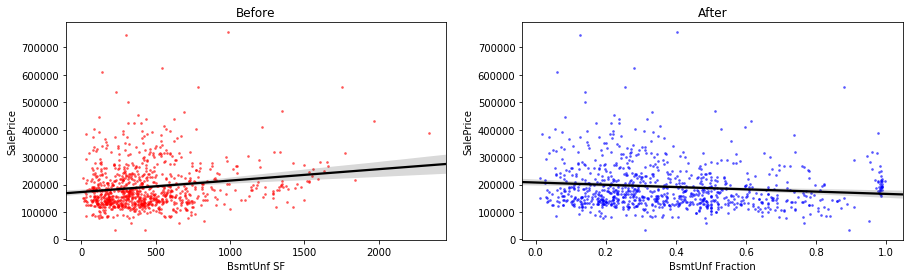

In [18]:
#plot demonstrates the eff
#ect of feature engineering
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df.loc[(df['BsmtUnfFrac']>0) & 
                   (df['BsmtUnfFrac']<1), 'BsmtUnfSF'],
            df.loc[(df['BsmtUnfFrac']>0) & 
                   (df['BsmtUnfFrac']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df.loc[(df['BsmtUnfFrac']>0) & 
                   (df['BsmtUnfFrac']<1), 'BsmtUnfFrac'],
            df.loc[(df['BsmtUnfFrac']>0) & 
                   (df['BsmtUnfFrac']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')


df.loc[:,df.columns.str.contains('Bsmt')].head(5)



---

## first floor and second floor feature engineering

---

Columns are created that represent the fraction of each property's area that is on the first floor, on the second floor, or unfinished.

Then columns are created for the total size of all interior areas, for the total area of living quarters, and for the total area of non-living quarter interiors.

In [0]:
#fraction of property's area on 1st, 2nd, or unfinished
df['LowQualFinFrac'] = df['LowQualFinSF']/df['GrLivArea']
df['1stFlrFrac'] = df['1stFlrSF']/df['GrLivArea']
df['2ndFlrFrac'] = df['2ndFlrSF']/df['GrLivArea']

In [0]:
df['TotalAreaSF'] = df['GrLivArea']+df['TotalBsmtSF']+df['GarageArea']+df['EnclosedPorch']+df['ScreenPorch']
df['LivingAreaSF'] = df['1stFlrSF']+df['2ndFlrSF']+df['BsmtGLQSF']+df['BsmtALQSF']+df['BsmtBLQSF']
df['StorageAreaSF'] = df['LowQualFinSF']+df['BsmtRecSF']+df['BsmtLwQSF']+df['BsmtUnfSF']+df['GarageArea']



---

## converting catagorical features into numeric scales


---



In [21]:
#convert Excellent, Good, Typical, Fair, Poor to 1-5 rate
cols_conv = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu',
             'GarageQual','GarageCond','PoolQC']

dict_numa = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_conv:
    df[col].replace(dict_numa, inplace=True)

display(df[cols_conv].head(5))    

ExterQual ExterCond  BsmtQual  ...  GarageQual GarageCond PoolQC
Id                                ...                              
1          4         3         4  ...           3          3      0
2          3         3         4  ...           3          3      0
3          4         3         4  ...           3          3      0
4          3         3         3  ...           3          3      0
5          4         3         4  ...           3          3      0

[5 rows x 10 columns]

In [0]:
#convert BsmtExposure from Gd, Av, Mn, No, and None, to rating scale 0 - 4
df['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)
#convert CentralAir Y, or N, to binary 1 or 0
df['CentralAir'].replace({'Y':1,'N':0}, inplace=True)
#convert Functional Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, and Sal, to rating scale 0 - 7
df['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
#convert GarageFinish Fin, RFn, Unf, and None to rating scale 0 - 3
df['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
#convert LotShape Reg, IR1, IR2, and IR3 to rating scale 0 - 3
df['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)
#convert Utilities AllPub, NoSewr, NoSeWa, and ELO to rating scale 0 - 3
df['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)
#convery LandSlope Gtl, Mod, and Sev, to rating scale 0 - 2
df['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)



---

## dealing with those pesky zeros

---



In [23]:
#fraction of zeros in each column
frac_zeros = ((df==0).sum()/len(df))

#unique values in columns
n_unique = df.nunique()

xs_zeros = frac_zeros - 1/n_unique

#create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])


df['HasPool'] = (df['PoolQC']>0).astype(int)
df['Has3SsnPorch'] = (df['3SsnPorch']>0).astype(int)
df.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)


df['BsmtFullBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
df['FullBath'] = df['FullBath'] + 0.5*df['HalfBath']
df.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)


frac_zeros  n_unique  xs_zeros
LowQualFinFrac    0.986297        39  0.960656
LowQualFinSF      0.986297        36  0.958519
3SsnPorch         0.987324        31  0.955066
MiscVal           0.964714        38  0.938398
PoolArea          0.995546        14  0.924118
BsmtLwQFrac       0.917437       225  0.912993
BsmtLwQSF         0.917437       199  0.912412
ScreenPorch       0.912299       121  0.904034
BsmtBLQFrac       0.885235       322  0.882129
BsmtBLQSF         0.885235       283  0.881701
BsmtRecFrac       0.865365       362  0.862602
BsmtRecSF         0.865365       302  0.862054
EnclosedPorch     0.842754       183  0.837290
BsmtALQFrac       0.835218       456  0.833025
BsmtALQSF         0.835218       370  0.832515
PoolQC            0.996574         4  0.746574
BsmtGLQFrac       0.697499       823  0.696284
BsmtGLQSF         0.697499       619  0.695884
BsmtHalfBath      0.940048         3  0.606715
MasVnrArea        0.603289       444  0.601037
2ndFlrFrac        0.571429      1040  0.570467
2ndFlrSF          0.571429       635  0.569854
WoodDeckSF        0.521754       379  0.519116
OpenPorchSF       0.444673       252  0.440705
BsmtFullBath      0.584789         4  0.334789
FireplaceQu       0.486468         6  0.319801
HalfBath          0.628297         3  0.294964
Fireplaces        0.486468         5  0.286468
BsmtUnfFrac       0.082905      1730  0.082327
BsmtUnfSF         0.082905      1135  0.082024
GarageArea        0.054128       603  0.052470
TotalBsmtSF       0.027064      1058  0.026119
StorageAreaSF     0.008565      1397  0.007849

In [0]:
#create additional dummy variable for
#continuous variables with many zeros
dummy_cols = ['LowQualFinSF','2ndFlrSF',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF',
              'BsmtLwQSF','BsmtUnfSF','TotalBsmtSF']

for col in dummy_cols:
    df['Has'+col] = (df[col]>0).astype(int)

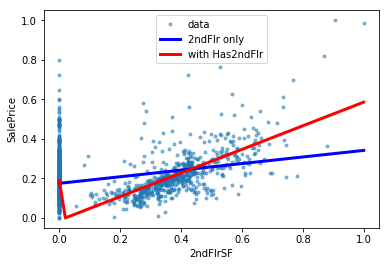

In [25]:
tmp = normalize(df[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice
X = tmp['2ndFlrSF']

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1),y)
lr_coefs = pd.Series(lr.coef_,index=['Has2ndFlrSF'])
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlr only')

tmp = normalize(df[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice

X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlrSF'] + has2nd*lr_coefs['Has2ndFlrSF'] + lr_intercept

plt.plot([0,0.02,1],[regval(0,0),regval(0.02,1),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

plt.legend()
plt.xlabel('2ndFlrSF')
plt.ylabel('SalePrice');



---

## peeping the distro of *SalePrice*

---



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


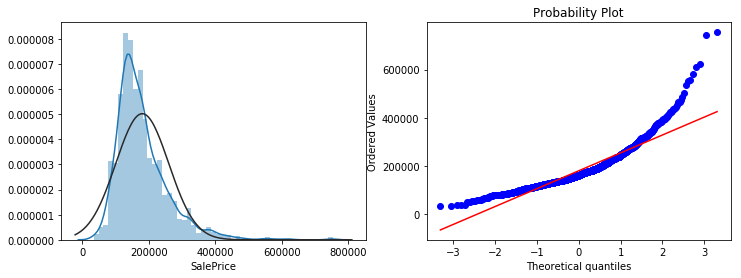

In [26]:
from scipy import stats
print(df.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df.SalePrice.dropna(), plot=plt)



---

## log transforming *SalePrice*

---
The rightly-skewed tail of the SalePrice has the nasty potential to hurt the performance of future model-fitting. To [Log Transform](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/), is to deal with skewed data. Unskew the sucker. Improve its normality. Look at the difference between the graphs directly above this text-cell and those directly below. Ain't it pretty? Log Transform. Yeah.


count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


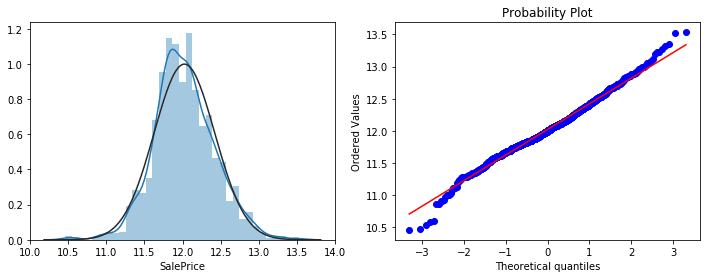

In [27]:
#Log Transform SalePrice
#this improves normality
sp = df.SalePrice
df.SalePrice = np.log(sp)

print(df.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)



---

## stratify those identity types

---



In [28]:
#list numerics
dtypes = df.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

#MSubClass should be categorical
cols_numeric.remove('MSSubClass')

#choose any numeric column with less than 13 values to be
#"discrete". 13 chosen to include months of the year. oth
#er columns are under the "continuous" catagory.
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')

76 numeric columns, of which 37 are continuous and 39 are discrete.


In [29]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

for col in cols_categ:
    df[col] = df[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

31 categorical columns.


In [30]:
print(cols_categ)

['Alley', 'BldgType', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'Functional', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


In [31]:
print(cols_continuous)

['1stFlrSF', '2ndFlrSF', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'BsmtGLQSF', 'BsmtALQSF', 'BsmtBLQSF', 'BsmtRecSF', 'BsmtLwQSF', 'BsmtGLQFrac', 'BsmtALQFrac', 'BsmtBLQFrac', 'BsmtRecFrac', 'BsmtLwQFrac', 'BsmtUnfFrac', 'LowQualFinFrac', '1stFlrFrac', '2ndFlrFrac', 'TotalAreaSF', 'LivingAreaSF', 'StorageAreaSF']


In [32]:
print(cols_discrete)

['BedroomAbvGr', 'BsmtCond', 'BsmtExposure', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'FireplaceQu', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'KitchenAbvGr', 'LandSlope', 'LotShape', 'MoSold', 'OverallCond', 'OverallQual', 'YrSold', 'HasPool', 'Has3SsnPorch', 'HasLowQualFinSF', 'Has2ndFlrSF', 'HasMiscVal', 'HasScreenPorch', 'HasWoodDeckSF', 'HasOpenPorchSF', 'HasEnclosedPorch', 'HasMasVnrArea', 'HasGarageArea', 'HasFireplaces', 'HasBsmtGLQSF', 'HasBsmtALQSF', 'HasBsmtBLQSF', 'HasBsmtRecSF', 'HasBsmtLwQSF', 'HasBsmtUnfSF', 'HasTotalBsmtSF']


In [0]:
def double_dippers(a, b):
  a_set = set(a)
  b_set = set(b)
  if(a_set & b_set):
     print(a_set & b_set)

In [0]:
double_dippers(cols_categ,cols_discrete)



---

## distro of SalePrice within the stratified catagoricals

---



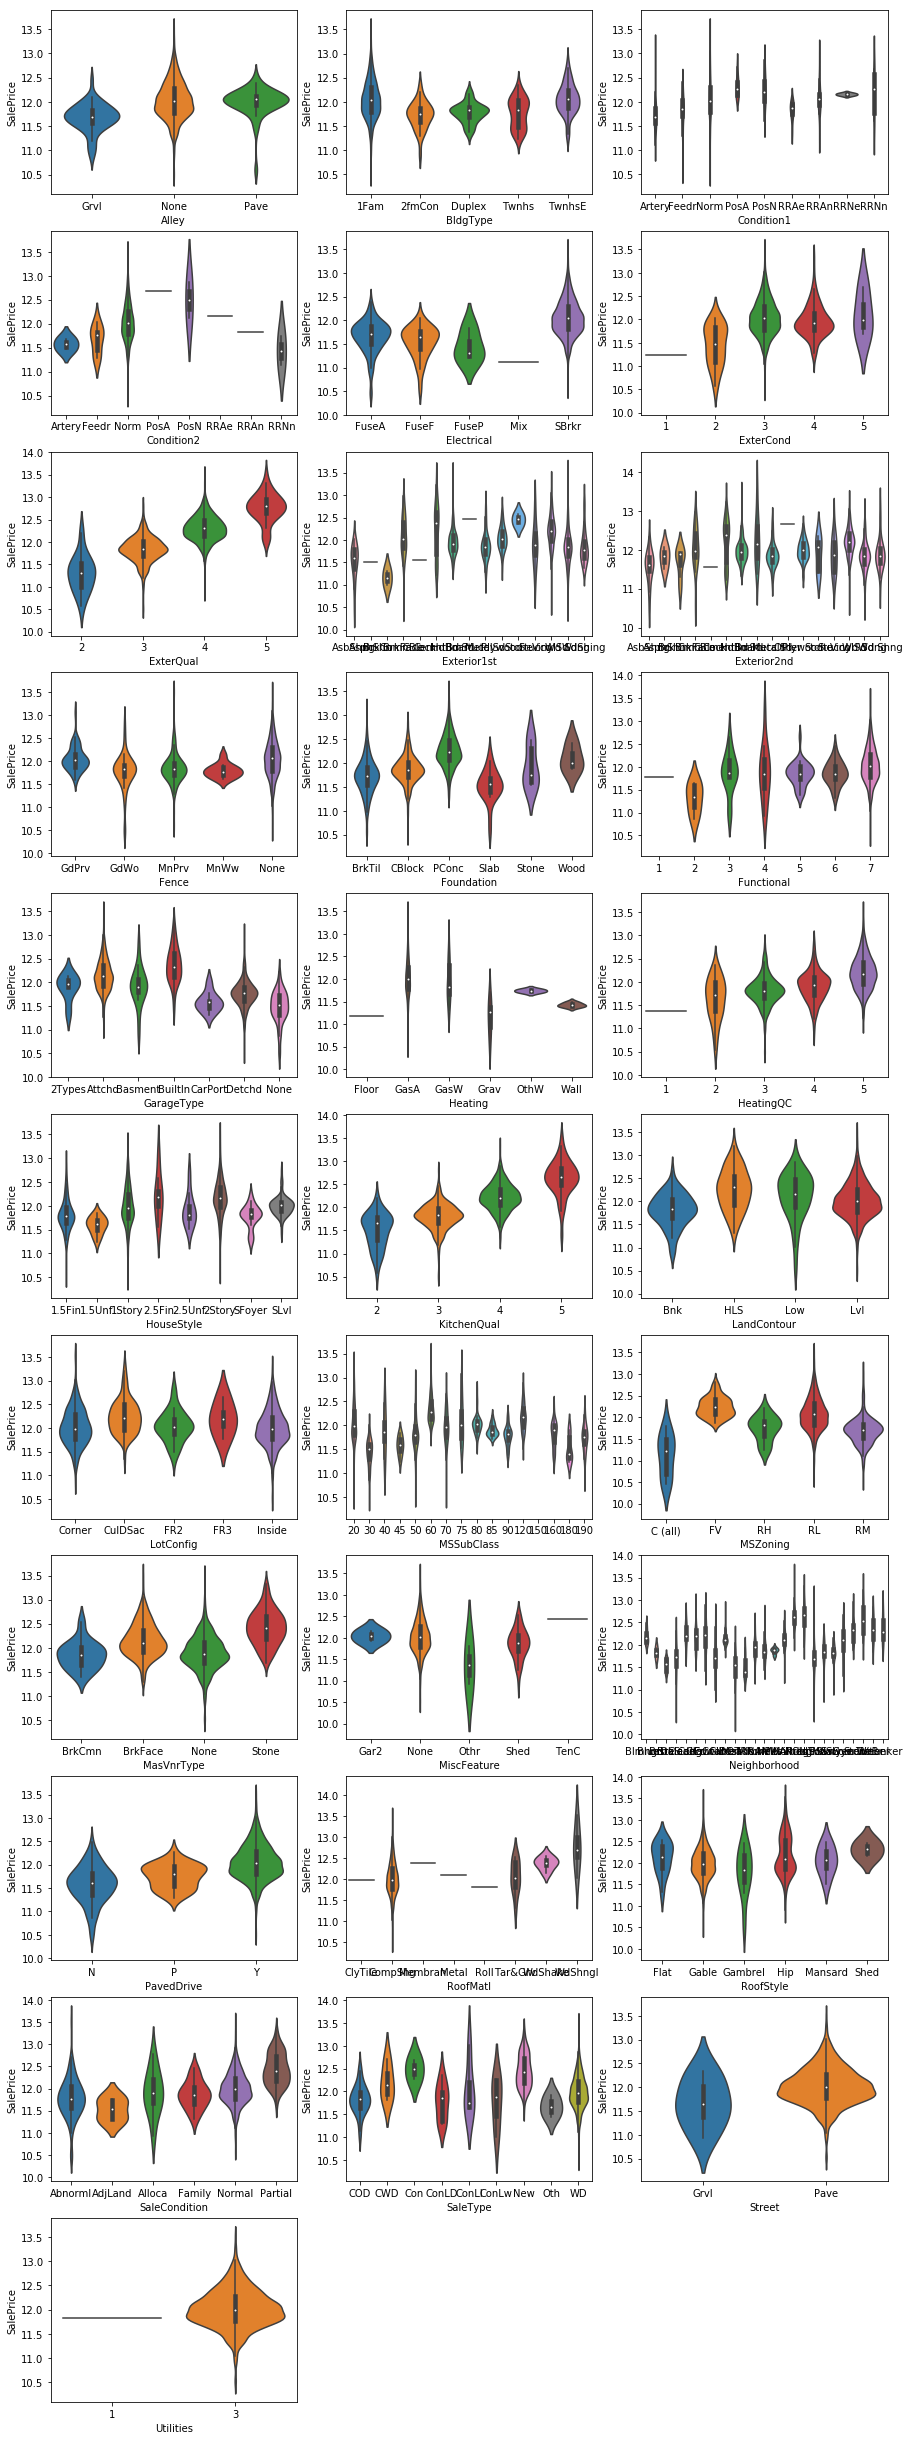

In [35]:
from math import ceil
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df[col],df['SalePrice'])

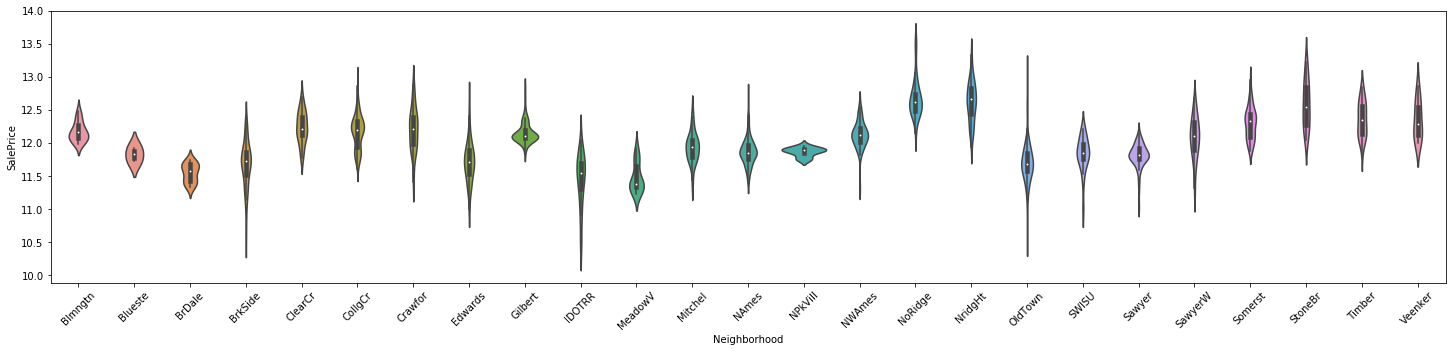

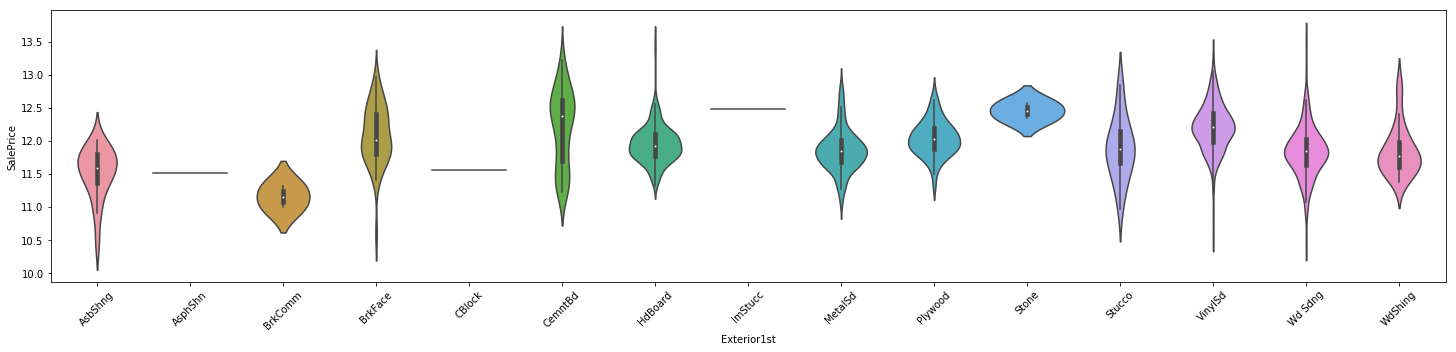

In [36]:
#Neighborhood column
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df)
plt.xticks(rotation=45);

#Exterior1st column
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df)
plt.xticks(rotation=45);



---

## significance of the categorical features

---

To gain insight into the importance of each categorical variable for SalePrice prediction, I'll employ [ANOVA](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/anova/), which finds out if my catagoricals are significant. Basically, I'm testing groups to see if there's a difference between them, or if one is better than the other.

What my ANOVA test figures, is that almost all of the categorical features have a significant affect toward the *SalePrice*, *Neighborhood*, *GarageType*, *MSubClass*, and *Foundation* seem to be the most important.

In [0]:
#anova test to check significance 
#of variation in column 'group' vs. column 'value' 
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of houses (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p  

In [38]:
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.043304e-243
ExterQual        6.935425e-195
KitchenQual      4.441486e-187
GarageType       8.427845e-125
MSSubClass       5.096023e-115
Foundation       1.350671e-111
HeatingQC         1.614882e-82
MasVnrType        1.670061e-65
MSZoning          1.021343e-59
Exterior1st       1.053128e-53
Exterior2nd       2.429938e-49
SaleCondition     1.689708e-41
SaleType          5.497893e-36
PavedDrive        1.090995e-31
Electrical        6.081144e-31
HouseStyle        1.636077e-30
ExterCond         6.540305e-14
Fence             6.560319e-13
RoofStyle         1.705740e-12
BldgType          3.436794e-12
Condition1        1.173444e-10
Alley             1.358108e-09
Heating           2.484312e-09
LandContour       3.086224e-08
LotConfig         6.214575e-07
Functional        4.250370e-06
RoofMatl          4.504239e-04
MiscFeature       6.059928e-03
Condition2        1.382042e-02
Street            2.837931e-02
Utilities         6.296094e-01
dtype: float64



---

## distro of *SalePrice* in discrete numeric features

---



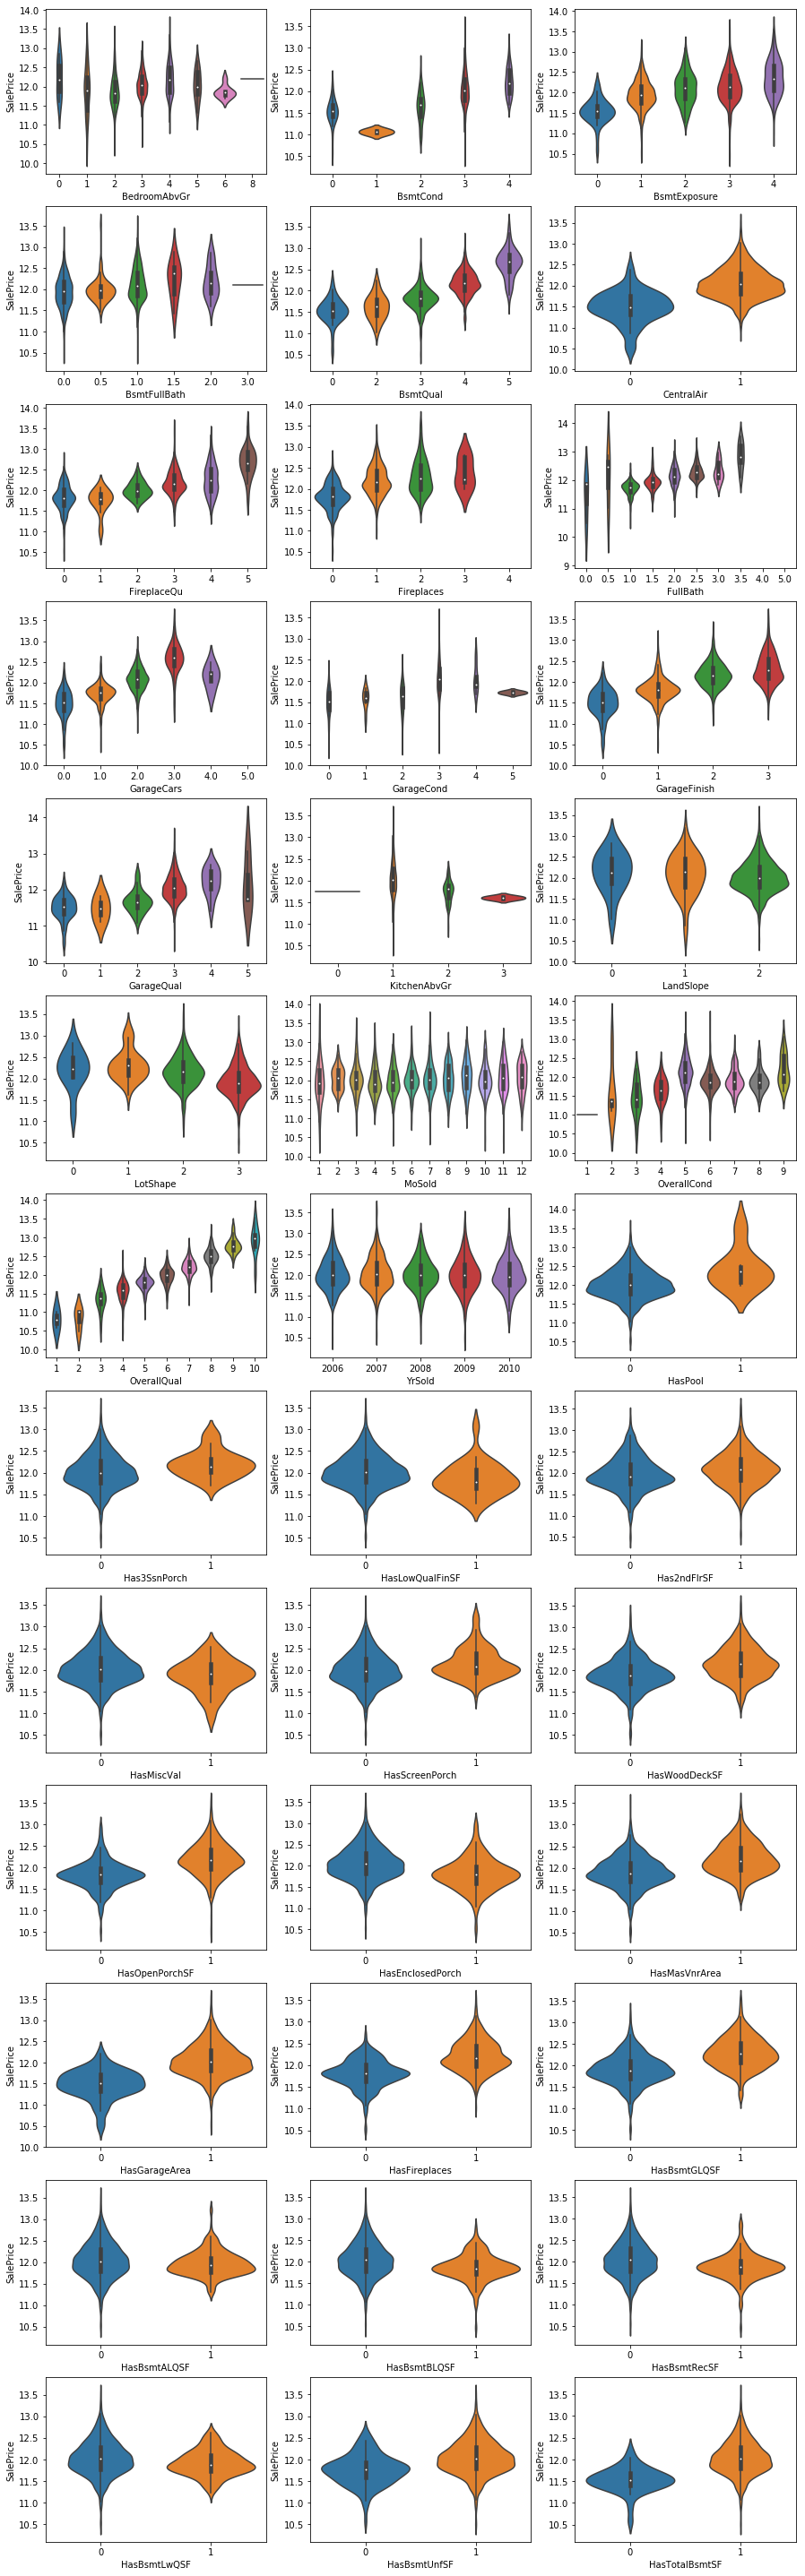

In [39]:
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df[col],df['SalePrice'])

ANOVA test says *GarageCars, ExterQual, BsmtQual, KitchenQual, FullBath, GarageFinish, GarageType, FireplaceQu*, and *Foundation* hold the most sway.

In [40]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual          0.000000e+00
GarageCars          5.539585e-211
BsmtQual            2.031282e-188
FullBath            3.733271e-167
GarageFinish        4.057458e-151
FireplaceQu         6.963458e-115
HasFireplaces        1.688600e-97
Fireplaces           7.485912e-97
HasOpenPorchSF       2.024867e-73
HasBsmtGLQSF         3.828370e-69
OverallCond          9.270535e-53
HasMasVnrArea        5.246135e-52
GarageCond           2.508058e-47
BsmtExposure         2.590707e-47
GarageQual           6.068406e-46
CentralAir           9.855628e-44
HasGarageArea        8.411473e-37
HasWoodDeckSF        3.391236e-36
LotShape             7.856968e-29
BsmtCond             1.492754e-27
BedroomAbvGr         2.473588e-20
BsmtFullBath         2.301539e-17
HasEnclosedPorch     5.905933e-17
HasTotalBsmtSF       1.370151e-14
HasBsmtUnfSF         1.603646e-13
Has2ndFlrSF          7.446444e-09
HasBsmtBLQSF         3.753273e-08
KitchenAbvGr         1.787541e-07
HasBsmtRecSF         3.164591e-07
HasScreenPorch



---

## distro of continuous variables and their *SalePrice* affect

---



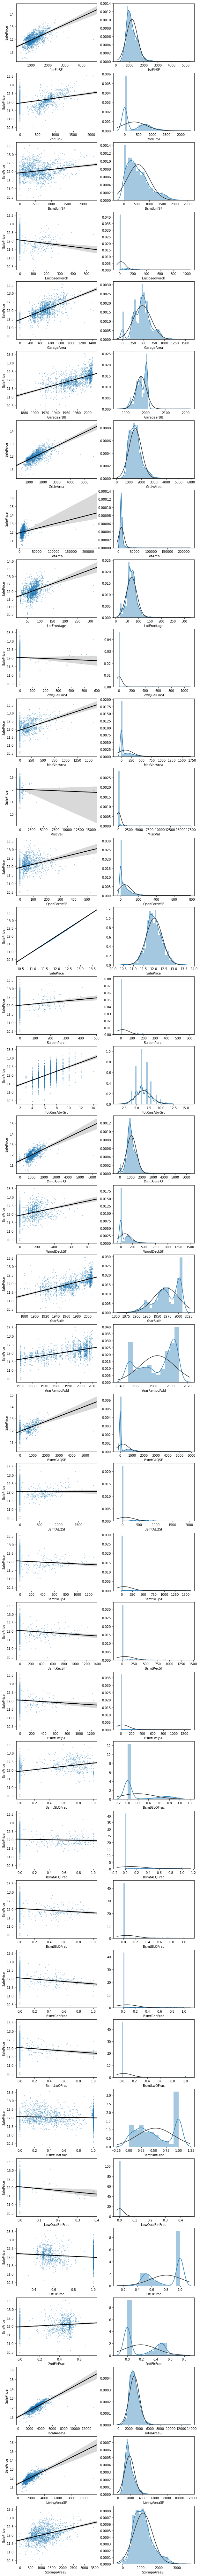

In [41]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df[col].dropna() , fit=stats.norm)
    plt.xlabel(col)



---

## correlation between numeric features

---



SalePrice         1.000000
TotalAreaSF       0.834994
OverallQual       0.809829
LivingAreaSF      0.753706
GrLivArea         0.731310
GarageCars        0.690711
BsmtQual          0.678026
FullBath          0.675455
YearBuilt         0.652682
GarageArea        0.649379
GarageFinish      0.633974
GarageYrBlt       0.612604
TotalBsmtSF       0.602725
1stFlrSF          0.575408
YearRemodAdd      0.571159
FireplaceQu       0.537602
TotRmsAbvGrd      0.532586
HasFireplaces     0.525735
Fireplaces        0.519247
HasOpenPorchSF    0.485350
Name: SalePrice, dtype: float64
-----------------
HasLowQualFinSF    0.068014
LowQualFinSF       0.067719
Has3SsnPorch       0.065329
HasMiscVal         0.063389
MiscVal            0.062727
BsmtALQSF          0.061374
HasPool            0.058428
LandSlope          0.050310
BsmtUnfFrac        0.036628
YrSold             0.029899
Name: SalePrice, dtype: float64


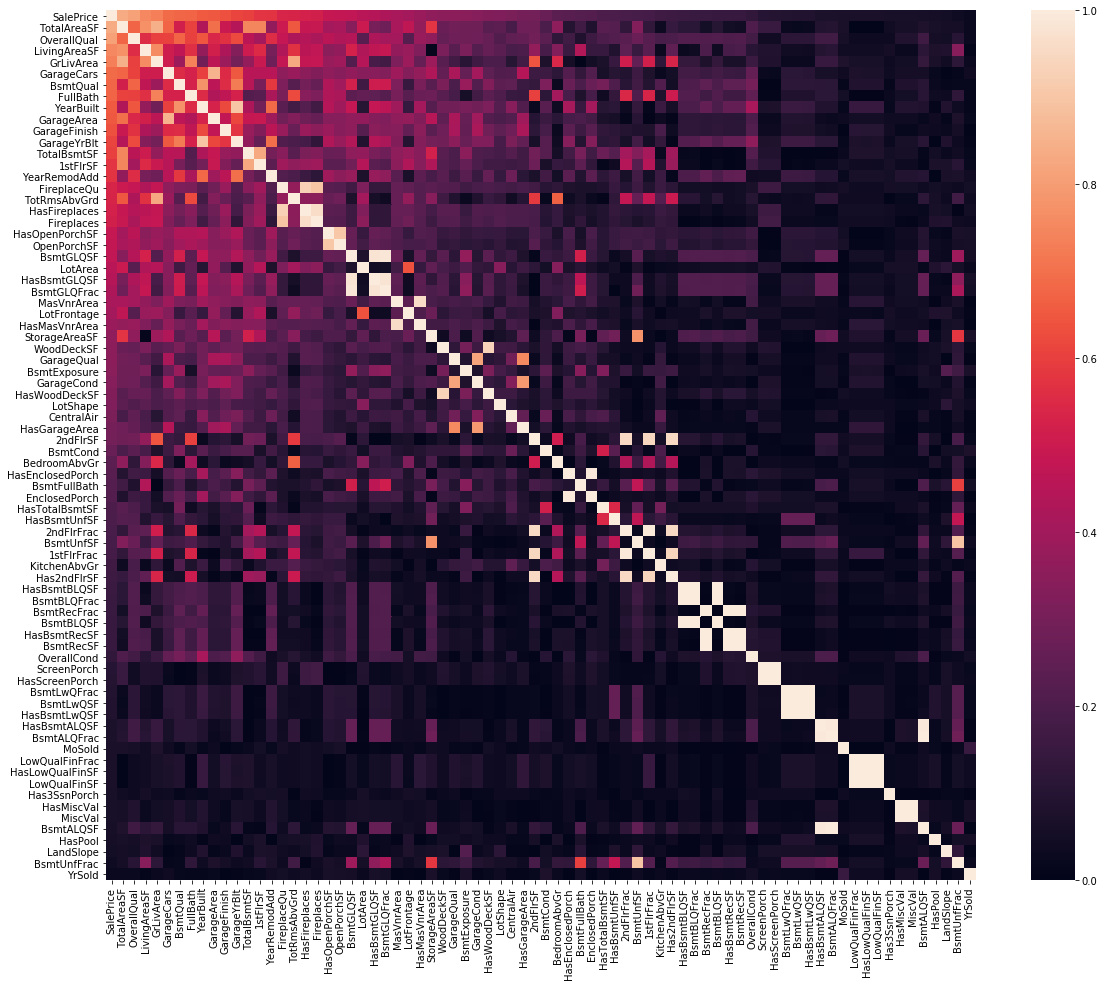

In [42]:
# correlation between numeric variables
df_corr = df.loc[train_id, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

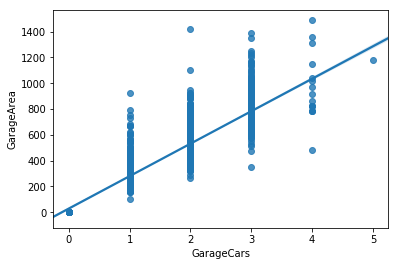

In [43]:
sns.regplot(x='GarageCars',y='GarageArea',data=df)



---

## those numeric features look beatnik, normalize them

---



In [44]:
# normalise numeric columns
scale_cols = [col for col in cols_numeric if col!='SalePrice']

df[scale_cols] = df[scale_cols].apply(normalize,axis=0)

df[scale_cols].describe()

1stFlrSF     2ndFlrSF  ...  HasBsmtUnfSF  HasTotalBsmtSF
count  2919.000000  2919.000000  ...   2919.000000     2919.000000
mean      0.173405     0.162946  ...      0.917095        0.972936
std       0.082412     0.207604  ...      0.275786        0.162298
min       0.000000     0.000000  ...      0.000000        0.000000
25%       0.113842     0.000000  ...      1.000000        1.000000
50%       0.157110     0.000000  ...      1.000000        1.000000
75%       0.221277     0.340920  ...      1.000000        1.000000
max       1.000000     1.000000  ...      1.000000        1.000000

[8 rows x 75 columns]



---

## transform continuous numeric features to improve normality

---



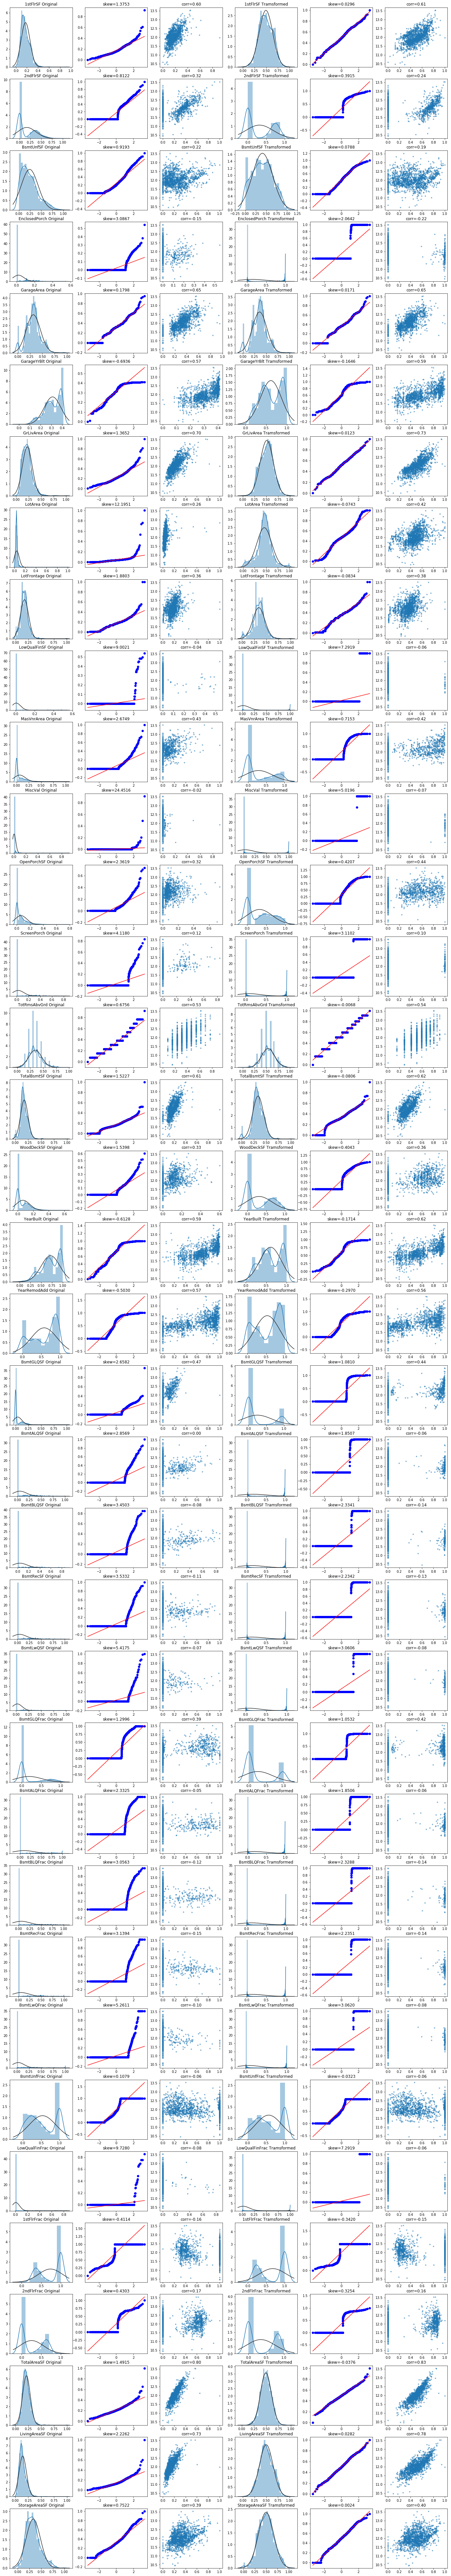

In [45]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='SalePrice':
        dat = df[[var, 'SalePrice']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['SalePrice'])[0][1]))
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = normalize(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['SalePrice'])[0][1]))



---

## box-cox transform suitable variables

---

Inspect the plots shown above and in so doing define a list of features for which the box-cox transform isn't necessarily viable. Then transform and re-normalize the remaining features.

In [46]:
# variables not suitable for box-cox transformation based on above (usually due to excessive zeros)
cols_notransform = ['2ndFlrSF','1stFlrFrac','2ndFlrFrac','StorageAreaSF',
                    'EnclosedPorch','LowQualFinSF','MasVnrArea',
                    'MiscVal','ScreenPorch','OpenPorchSF','WoodDeckSF','SalePrice',
                    'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF','BsmtLwQSF','BsmtUnfSF',
                    'BsmtGLQFrac','BsmtALQFrac','BsmtBLQFrac','BsmtRecFrac','BsmtLwQFrac','BsmtUnfFrac']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

#transform remaining variables
print('Transforming',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    # transform column
    df.loc[:,col], _ = stats.boxcox(df.loc[:,col]+1)
    
    # renormalise column
    df.loc[:,col] = normalize(df.loc[:,col])

Transforming 13 columns: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'LowQualFinFrac', 'TotalAreaSF', 'LivingAreaSF']




---

## preparing datas for model fitting

---

Last stop before fitting is figuring what in tarnation is to be done with the remaining catagorical features. 

That is, one-hot encode them, creating a binary indicator for each possible feature value using pandas, which increases the number of variables in the dataset from about 100 to around 250. 

In [47]:
# select which features to use (all for now)
model_cols = df.columns

# encode categoricals
df_model = pd.get_dummies(df[model_cols])

# Rather than including Condition1 and Condition2, or Exterior1st and Exterior2nd,
# combine the dummy variables (allowing 2 true values per property)
if ('Condition1' in model_cols) and ('Condition2' in model_cols):
    
    cond_suffix = ['Artery','Feedr','Norm','PosA','PosN','RRAe','RRAn','RRNn']
    
    for suffix in cond_suffix:
        col_cond1 = 'Condition1_'+suffix
        col_cond2 = 'Condition2_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
if ('Exterior1st' in model_cols) and ('Exterior2nd' in model_cols):
    
    # some different strings in Exterior1st and Exterior2nd for same type - rename columns to correct
    df_model.rename(columns={'Exterior2nd_Wd Shng':'Exterior2nd_WdShing',
                             'Exterior2nd_Brk Cmn':'Exterior2nd_BrkComm',
                             'Exterior2nd_CmentBd':'Exterior2nd_CemntBd'},inplace=True)

    ext_suffix = ['AsphShn','BrkComm','BrkFace','CBlock','CemntBd',
                    'HdBoard','ImStucc','MetalSd','Plywood','Stone',
                    'Stucco','VinylSd','Wd Sdng','WdShing','AsbShng']
    
    for suffix in ext_suffix:
        col_cond1 = 'Exterior1st_'+suffix
        col_cond2 = 'Exterior2nd_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
display(df_model.head())

1stFlrSF  2ndFlrSF  BedroomAbvGr  ...  Street_Pave  Utilities_1  Utilities_3
Id                                    ...                                       
1   0.362867  0.413559         0.375  ...            1            0            1
2   0.543162  0.000000         0.375  ...            1            0            1
3   0.395939  0.419370         0.375  ...            1            0            1
4   0.416107  0.366102         0.375  ...            1            0            1
5   0.497820  0.509927         0.500  ...            1            0            1

[5 rows x 271 columns]

In [0]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = df_model.loc[train_id]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return df_model.loc[test_id].drop('SalePrice',axis=1)

In [49]:
get_training_data()
get_test_data()

1stFlrSF  2ndFlrSF  BedroomAbvGr  ...  Street_Pave  Utilities_1  Utilities_3
Id                                      ...                                       
1461  0.383769  0.000000         0.250  ...            1            0            1
1462  0.567099  0.000000         0.375  ...            1            0            1
1463  0.399935  0.339467         0.375  ...            1            0            1
1464  0.398938  0.328329         0.375  ...            1            0            1
1465  0.549731  0.000000         0.250  ...            1            0            1
1466  0.311092  0.431961         0.375  ...            1            0            1
1467  0.514641  0.000000         0.375  ...            1            0            1
1468  0.326033  0.327361         0.375  ...            1            0            1
1469  0.571240  0.000000         0.250  ...            1            0            1
1470  0.376543  0.000000         0.250  ...            1            0            1
1471  0.569864  0.000000         0.250  ...            1            0            1
1472  0.123601  0.244068         0.250  ...            1            0            1
1473  0.155165  0.274576         0.375  ...            1            0            1
1474  0.362335  0.291041         0.375  ...            1            0            1
1475  0.352117  0.000000         0.250  ...            1            0            1
1476  0.658384  0.342373         0.375  ...            1            0            1
1477  0.635218  0.000000         0.375  ...            1            0            1
1478  0.676978  0.000000         0.375  ...            1            0            1
1479  0.706986  0.000000         0.375  ...            1            0            1
1480  0.853570  0.000000         0.375  ...            1            0            1
1481  0.674168  0.272639         0.375  ...            1            0            1
1482  0.581073  0.000000         0.250  ...            1            0            1
1483  0.565360  0.000000         0.375  ...            1            0            1
1484  0.497820  0.000000         0.250  ...            1            0            1
1485  0.299934  0.305085         0.375  ...            1            0            1
1486  0.358055  0.429056         0.375  ...            1            0            1
1487  0.663201  0.401937         0.500  ...            1            0            1
1488  0.649641  0.000000         0.250  ...            1            0            1
1489  0.526660  0.000000         0.250  ...            1            0            1
1490  0.612549  0.000000         0.250  ...            1            0            1
...        ...       ...           ...  ...          ...          ...          ...
2890  0.235731  0.000000         0.250  ...            1            0            1
2891  0.418995  0.324939         0.500  ...            1            0            1
2892  0.290980  0.000000         0.250  ...            1            0            1
2893  0.461771  0.162712         0.500  ...            1            0            1
2894  0.191737  0.174334         0.250  ...            0            0            1
2895  0.696680  0.000000         0.250  ...            1            0            1
2896  0.663466  0.000000         0.250  ...            1            0            1
2897  0.657844  0.000000         0.375  ...            1            0            1
2898  0.668209  0.000000         0.500  ...            1            0            1
2899  0.619563  0.000000         0.375  ...            1            0            1
2900  0.523590  0.000000         0.375  ...            1            0            1
2901  0.664526  0.000000         0.250  ...            1            0            1
2902  0.591968  0.000000         0.250  ...            1            0            1
2903  0.737065  0.000000         0.375  ...            1            0            1
2904  0.710644  0.000000         0.375  ...            1            0            1
2905  0.651022  0.0000



---

## outlier removal service: you flag 'em, we snag 'em

---
Using a straightforward model, I flag any outliers. The standard deviation of the residuals is calculated, and the twenty-odd properties with residuals greater than three times its standard deviation are removed from the training data so they don't get the chance to skew the parameters of the fitted models.


In [0]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [0]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.9404870676000541
rmse= 0.09741399396339481
---------------------------------------
mean of residuals: -1.2093826701122254e-15
std of residuals: 0.09744737206749698
---------------------------------------
22 outliers:
[31, 89, 411, 463, 496, 524, 582, 589, 629, 633, 729, 875, 899, 969, 971, 1063, 1182, 1183, 1299, 1325, 1433, 1454]


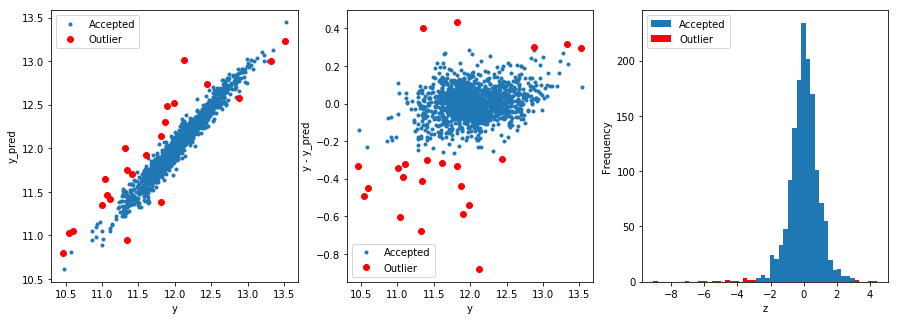

In [52]:
# get training data
X, y = get_training_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X, y)

# permanently remove these outliers from the data
df_model = df_model.drop(outliers)
train_id = train_id.drop(outliers)



---

## fit and optimize models

---
I don't want to overwork myself, so I create a function to perform the fitting process for each model type. I use k-fold cross-validation to reduce the chances of overfitting the training data, that is, 5-fold cross-validation repeated 5 times.

The parameters of each model are optimized using a grid search and the function returns the best model found and some stats on the model performance. 

The optimized models are Linear Regression, Support Vector Machines, Nearest Neighbors, and Tree Based.


In [0]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5


---

# Linear Regression

---
## Ridge Model

---




Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    8.5s finished


----------------------
Ridge(alpha=1.75, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.9611237673060848
rmse= 0.07630687317897969
cross_val: mean= 0.09439189579556334 , std= 0.0055226723762432095


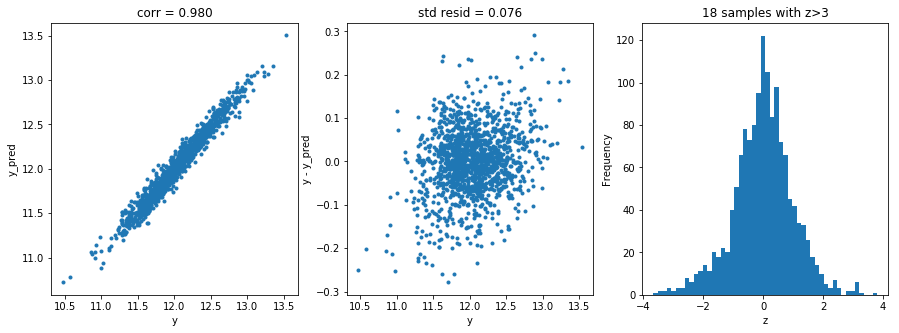

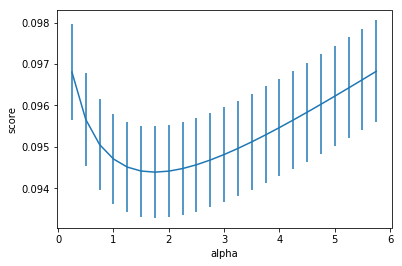

In [54]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

---
## Lasso Model
---

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   36.9s finished


----------------------
Lasso(alpha=0.00022000000000000003, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9577840401683012
rmse= 0.07951698510322201
cross_val: mean= 0.09072658615271255 , std= 0.003955360273136933


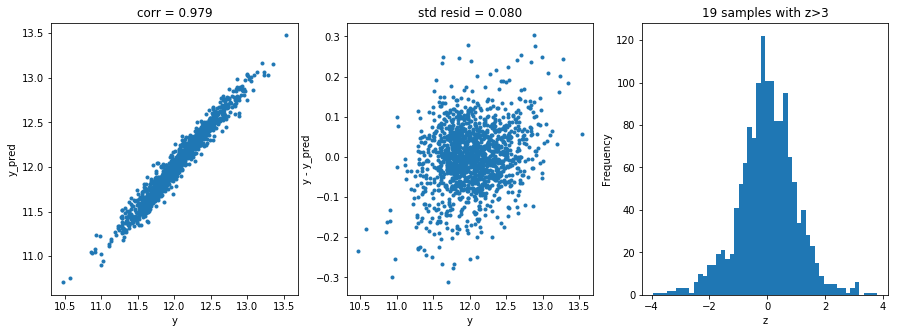

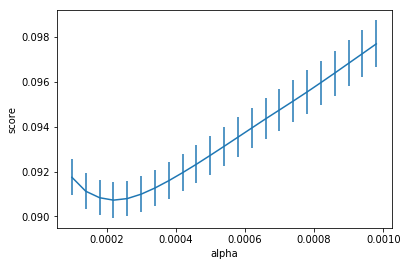

In [55]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');



---

## ElasticNet Model

---



Fitting 25 folds for each of 81 candidates, totalling 2025 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2025 out of 2025 | elapsed:  3.0min finished


----------------------
ElasticNet(alpha=0.0002, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9586028118966333
rmse= 0.07874209996679764
cross_val: mean= 0.09159188240718122 , std= 0.0048553285503952805


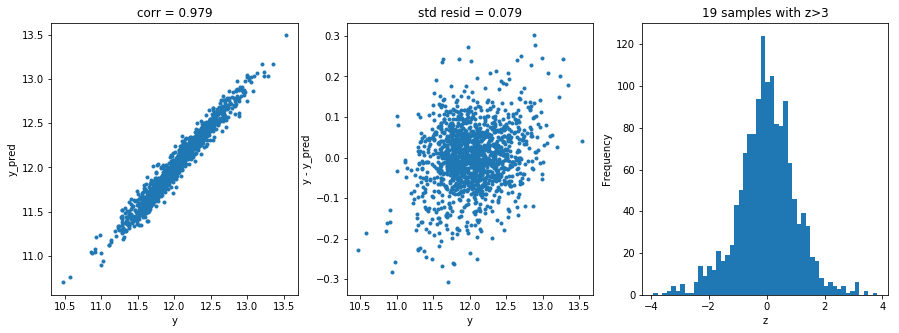

In [56]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)



---

# Support Vector Machines (SVM)

---

## Linear Model

---



Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  8.8min finished


----------------------
LinearSVR(C=0.9, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100000,
          random_state=None, tol=0.0001, verbose=0)
----------------------
score= 0.959172000956946
rmse= 0.07819889556055688
cross_val: mean= 0.10507403700900221 , std= 0.009668471566492146


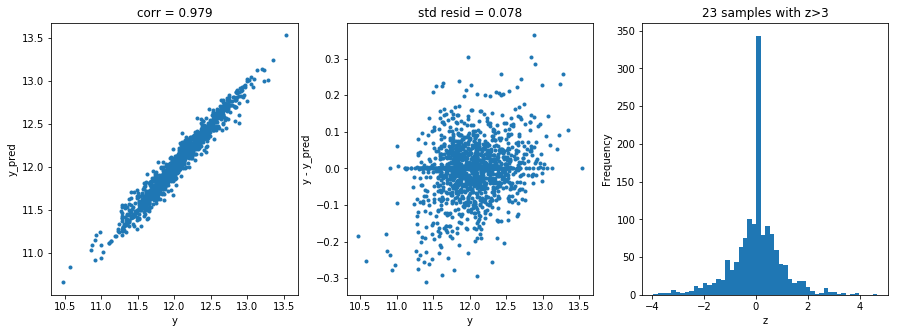

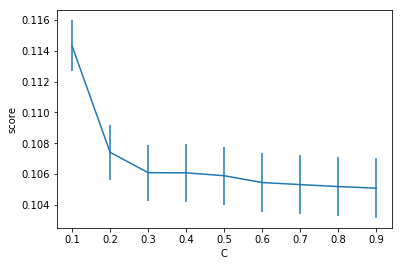

In [57]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score');



---

## Non-Linear Model

---



Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.0min finished


----------------------
SVR(C=19, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
----------------------
score= 0.9529031056099211
rmse= 0.08398809031270175
cross_val: mean= 0.09631928936044243 , std= 0.005437817462225815


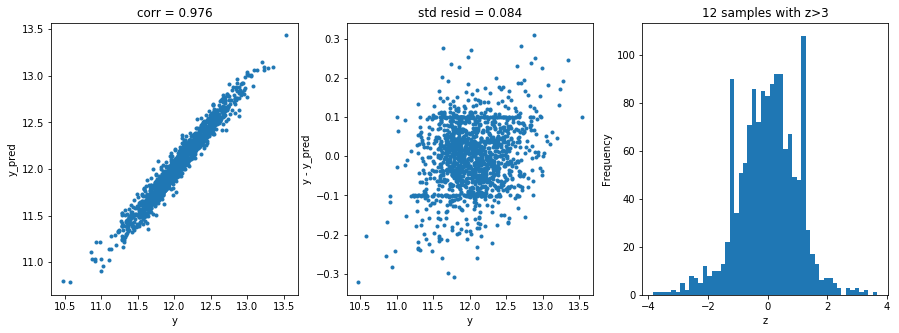

In [58]:
model ='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(1,21,2),
              'kernel':['poly','rbf','sigmoid'],
              'gamma':['auto']}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)



---

## KNeighbors Model

---



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   34.2s finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
----------------------
score= 0.8607616799228504
rmse= 0.1444112272675619
cross_val: mean= 0.17913825513086779 , std= 0.011287170810571423


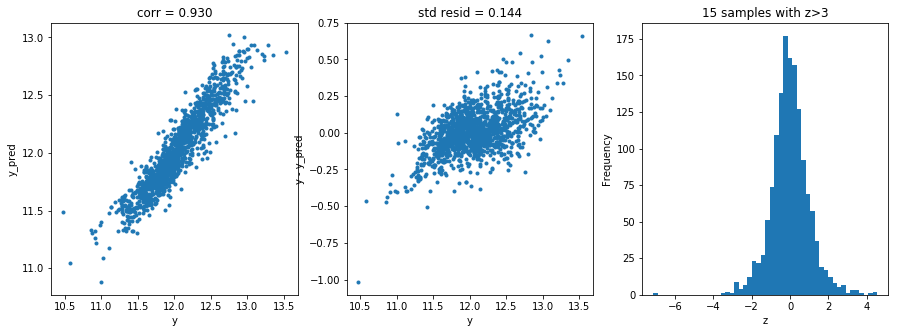

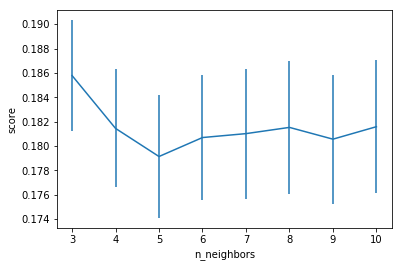

In [59]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score');



---

# Tree Based

---

## Random Forest

---



Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.9min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
score= 0.9872604814170098
rmse= 0.04368155394341318
cross_val: mean= 0.11769426786691688 , std= 0.011918714397865333


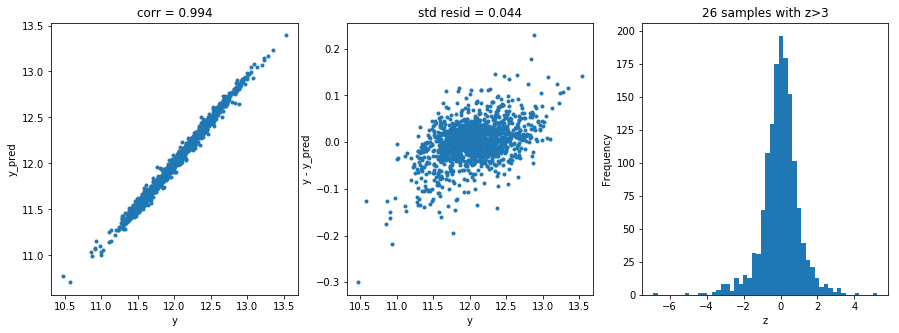

In [60]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)



---

## Gradient Boosting Model

---



Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.1min finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=350,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.9881639266669846
rmse= 0.04210419758280994
cross_val: mean= 0.10232358668661946 , std= 0.00629231100416284


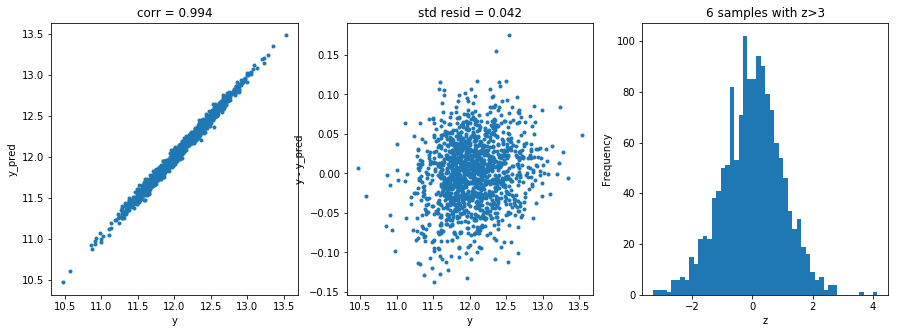

In [61]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)



---

## XGBoost Model

---



Fitting 5 folds for each of 15 candidates, totalling 75 fits
[19:24:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.2min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
----------------------
score= 0.9765655553216132
rmse= 0.059244618154584934
cross_val: mean= 0.10083717353555906 , std= 0.006014589113301144


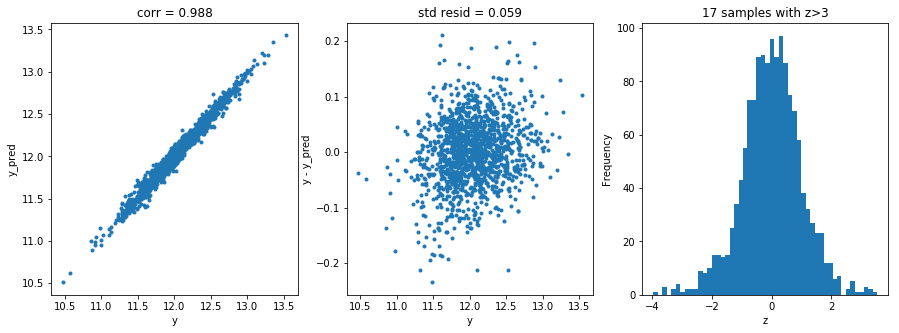

In [62]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)



---

## comparing the models

---



mean       std
Lasso             0.090727  0.003955
ElasticNet        0.091592  0.004855
Ridge             0.094392  0.005523
SVR               0.096319  0.005438
XGB               0.100837  0.006015
GradientBoosting  0.102324  0.006292
LinearSVR         0.105074  0.009668
RandomForest      0.117694  0.011919
KNeighbors        0.179138  0.011287

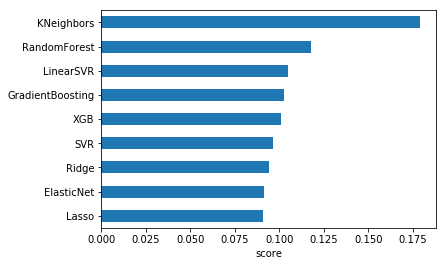

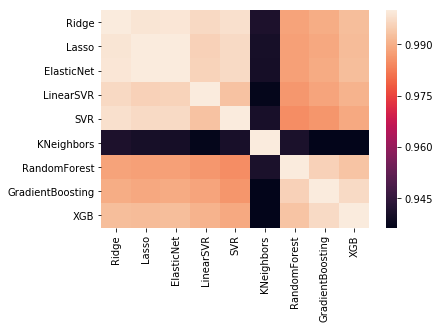

In [63]:
X,y = get_training_data()

Y_models = pd.DataFrame(index=y.index)    

for key, model in opt_models.items():
    Y_models[key] = model.predict(X)

corr_models = pd.DataFrame(Y_models).corr()

score_models = score_models.sort_values(by='mean')

display(score_models)
score_models['mean'].plot.barh()
plt.xlabel('score')

plt.figure()
sns.heatmap(corr_models)



---

## and the winner is: ElasticNet

---



---------------------------------------
132 zero coefficients
138 non-zero coefficients
---------------------------------------
Intercept:  10.40238430102617
---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
TotalAreaSF             0.609956
OverallQual             0.367150
OverallCond             0.328484
1stFlrSF                0.281256
LotArea                 0.248295
YearBuilt               0.246392
2ndFlrSF                0.227962
LivingAreaSF            0.166777
GrLivArea               0.148064
BsmtGLQSF               0.119319
Neighborhood_StoneBr    0.112675
FullBath                0.111735
TotalBsmtSF             0.099626
RoofMatl_WdShngl        0.094408
Exterior1st_BrkFace     0.088015
Neighborhood_Crawfor    0.085364
Functional_7            0.085363
OpenPorchSF             0.081244
KitchenQual_5           0.078776
Fireplaces              0.076531
dtype: float64
---------------------------------------
Top 10 

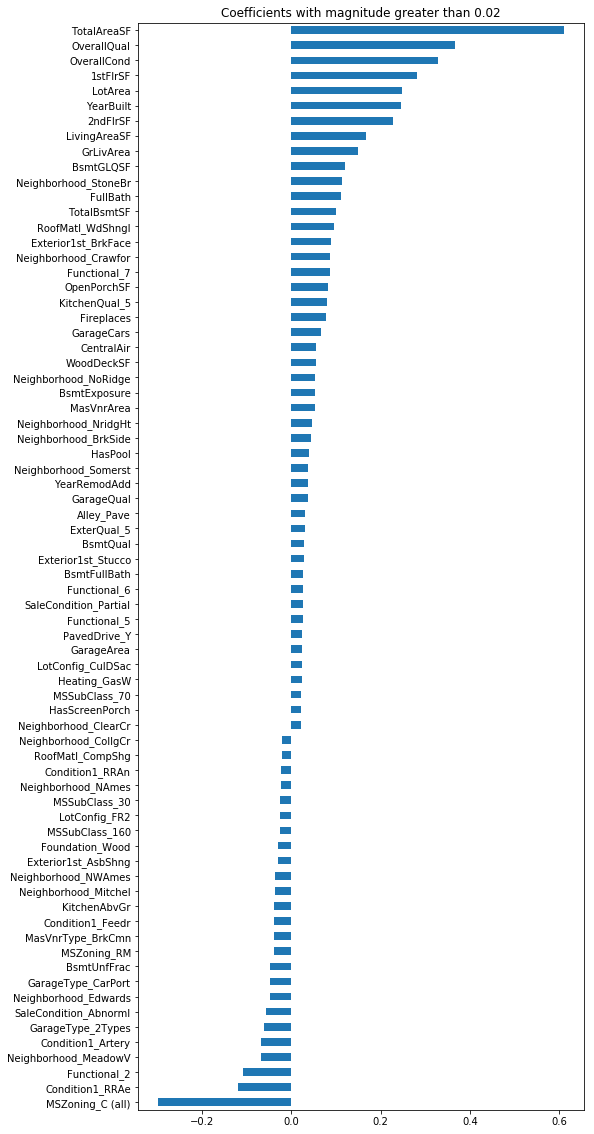

In [64]:
# get coefficients from previously optimised ElasticNet model
en_coefs = pd.Series(opt_models['ElasticNet'].coef_,index=X.columns)

plt.figure(figsize=(8,20))
en_coefs[en_coefs.abs()>0.02].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.02')

print('---------------------------------------')
print(sum(en_coefs==0),'zero coefficients')
print(sum(en_coefs!=0),'non-zero coefficients')
print('---------------------------------------')
print('Intercept: ',opt_models['ElasticNet'].intercept_)
print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 10 contributers to decreased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=True).head(10))
print('---------------------------------------')
print('Zero coefficients:')
print('---------------------------------------')
print(en_coefs[en_coefs==0].index.sort_values().tolist())



---

# Find Useful Interactions

---



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   15.9s finished


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9415045129544516
rmse= 0.09360148783257169
cross_val: mean= 0.10455124920933437 , std= 0.0041025799836010065
------------------------
475 zero coefficients
121 non-zero coefficients
66 non-zero interaction terms.
------------------------
Features with largest coefficients:
------------------------
33                   TotalAreaSF,
275     GarageArea, KitchenAbvGr,
21                   OverallCond,
16                       LotArea,
235        Fireplaces, YearBuilt,
34                  LivingAreaSF,
36        1stFlrSF, BsmtExposure,
286        GarageArea, YearBuilt,
31                   BsmtUnfFrac,
22                   OverallQual,
514     OverallCond, BsmtUnfFrac,
509    OverallCond, YearRemodAdd,
330    GarageFinish, OverallQual,
17

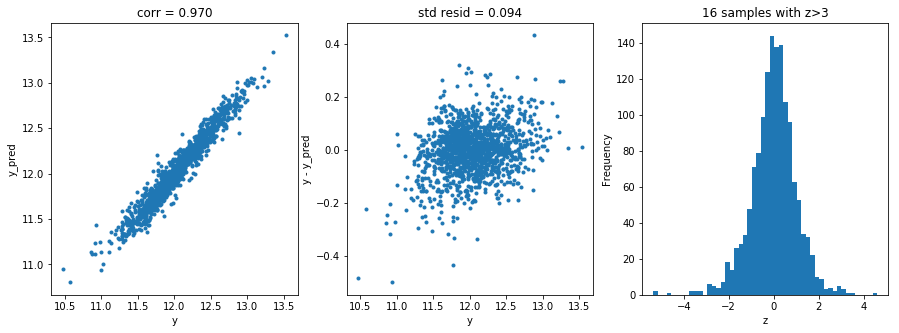

In [65]:
X,y=get_training_data()

#restrict to non-binary columns with non-zero coefficients only
select_cols = [col for col in X.columns if X[col].nunique()>2 and en_coefs[col]!=0]
X = X[select_cols]

# add interaction terms (x1*x2, but not x1**2) for all remaining features
poly = PolynomialFeatures(interaction_only=True)
X_poly = poly.fit_transform(X,y)
X_poly = pd.DataFrame(X_poly,index=y.index)

# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(poly.powers_,columns=X.columns)

s = np.where(powers>0, pd.Series(X.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])

# fit a new model with the interaction terms
alph_range = np.arange(5e-5,2e-4,2e-5)
param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'max_iter':[100000]}

model,_,_ = train_model(Lasso(), X=X_poly,y=y,param_grid=param_grid, 
                                              splits=splits, repeats=1)

poly_coefs = pd.Series(model.coef_)

print('------------------------')
print(sum(poly_coefs==0),'zero coefficients')
print(sum(poly_coefs!=0),'non-zero coefficients')
print(len(poly_coefs[(powers.sum(axis=1)==2) & (poly_coefs>0)]),'non-zero interaction terms.')
print('------------------------')
print('Features with largest coefficients:')
print('------------------------')
print(poly_terms[poly_coefs.abs().sort_values(ascending=False).index[:30]])
print('------------------------')



---

# Important Interactions

---



In [67]:
# sort coefficients by magnitude, and calculate no. features that contribute
# to the polynomial term that coefficient represents.
poly_coef_nterms = powers.loc[poly_coefs.abs().sort_values(ascending=False).index].sum(axis=1)

# extract n_ints top interactions (interactions have 2 non-zero features in the powers vector)
n_ints = 20
top_n_int_idx = poly_coef_nterms[poly_coef_nterms==2].head(n_ints).index

# create a column for each of the top n_ints interactions in df_model
for idx in top_n_int_idx:
    # extract names of columns to multiply
    int_terms = powers.loc[idx]
    int_terms = int_terms[int_terms==1].index    
    term1 = int_terms[0]
    term2 = int_terms[1]
    
    # create interaction column
    df_model[term1+'_x_'+term2] = normalize(df_model[term1]*df_model[term2])

# have a look at the new columns
display(df_model[df_model.columns[df_model.columns.str.contains('_x_')]].head(5))

GarageArea_x_KitchenAbvGr  ...  BsmtQual_x_LandSlope
Id                             ...                      
1                    0.297894  ...                   0.8
2                    0.253005  ...                   0.8
3                    0.327952  ...                   0.8
4                    0.344796  ...                   0.6
5                    0.438464  ...                   0.8

[5 rows x 20 columns]



---

# Fit a New Model

---



Fitting 25 folds for each of 81 candidates, totalling 2025 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2025 out of 2025 | elapsed:  5.9min finished


----------------------
ElasticNet(alpha=0.00030000000000000003, copy_X=True, fit_intercept=True,
           l1_ratio=0.7000000000000001, max_iter=100000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.9595576738375218
rmse= 0.07782867468896444
cross_val: mean= 0.09003796072873199 , std= 0.003977475441690446
------------------------
161 zero coefficients
129 non-zero coefficients
--------------------------
Interaction Coefficients:
--------------------------
OverallQual_x_TotalBsmtSF     0.222334
BsmtQual_x_TotalBsmtSF        0.143578
1stFlrSF_x_BsmtExposure       0.124408
GarageArea_x_YearBuilt        0.122879
Fireplaces_x_OverallCond      0.097777
OverallCond_x_BsmtUnfFrac     0.078887
FullBath_x_LotShape           0.052411
BsmtQual_x_OverallQual        0.047200
YearBuilt_x_YrSold            0.046884
YrSold_x_BsmtRecFrac          0.027142
GarageFinish_x_Overal

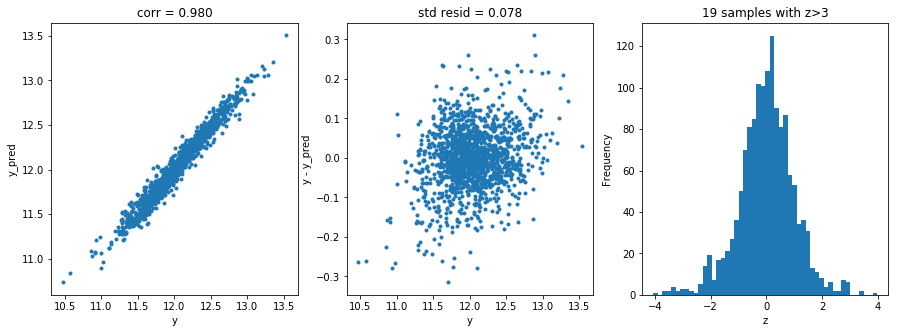

In [68]:
# fit a new model including the added interaction terms
en_int = ElasticNet()
alph_range = np.arange(5e-5,5e-4,2e-5)
param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

en_int, cv_score, grid_results = train_model(en_int, param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

X,y=get_training_data()
en_int_coef = pd.Series(en_int.coef_,index=X.columns)
print('------------------------')
print(sum(en_int_coef==0),'zero coefficients')
print(sum(en_int_coef!=0),'non-zero coefficients')
print('--------------------------')
print('Interaction Coefficients:')
print('--------------------------')
print(en_int_coef[en_int_coef.index.str.contains('_x_')].sort_values(ascending=False))
print('---------------------------------------')
print('Top 10 contributers to increased price:')
print('---------------------------------------')
print(en_int_coef.sort_values(ascending=False).head(10))
print('---------------------------------------')
print('Top 5 contributers to decreased price:')
print('---------------------------------------')
print(en_int_coef.sort_values(ascending=True).head(5))
print('---------------------------------------')



---

# Make Predictions

---



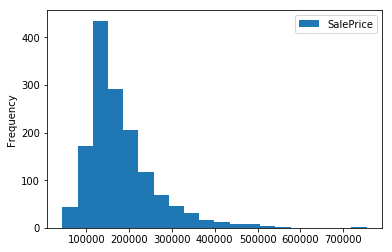

In [69]:
def predict_test(model):
    # get test data
    X_test = get_test_data()

    # predict SalePrices
    y_test = model.predict(X_test)

    #revert log transformation
    y_test = np.exp(y_test)

    # make a data frame suitable for creating submission files0.11571
    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test
# predict sale prices
y_test = predict_test(en_int)

# make submission file
y_test.to_csv('submission.csv')

# overview of what sale prices were predicted
y_test.plot.hist(bins=20)



---

# The End

---

